**Time Series Cryptocurrency**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!unzip "/content/drive/MyDrive/Dicoding/Sub2-Time Series Cryptocurrency/Time Series Cryptocurrency.zip"

Archive:  /content/drive/MyDrive/Dicoding/Sub2-Time Series Cryptocurrency/Time Series Cryptocurrency.zip
  inflating: gemini_BTCUSD_2020_1min.csv  
  inflating: gemini_ETHUSD_2020_1min.csv  
  inflating: gemini_LTCUSD_2020_1min.csv  


In [ ]:
import pandas as pd

dataset = pd.read_csv("/content/gemini_LTCUSD_2020_1min.csv")
dataset

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.618880e+12,4/20/2021 0:03,LTCUSD,260.05,260.05,259.00,259.00,179.16470
1,1.618880e+12,4/20/2021 0:02,LTCUSD,262.77,262.86,260.00,260.05,307.77795
2,1.618880e+12,4/20/2021 0:01,LTCUSD,263.57,264.14,262.77,262.77,11.53982
3,1.618880e+12,4/20/2021 0:00,LTCUSD,261.32,263.76,261.32,263.57,110.88182
4,1.618880e+12,4/19/2021 23:59,LTCUSD,261.87,261.87,261.21,261.32,48.58221
...,...,...,...,...,...,...,...,...
658006,1.577840e+12,1/1/2020 0:04,LTCUSD,41.26,41.26,41.26,41.26,0.00000
658007,1.577840e+12,1/1/2020 0:03,LTCUSD,41.26,41.26,41.26,41.26,0.00000
658008,1.577840e+12,1/1/2020 0:02,LTCUSD,41.26,41.26,41.26,41.26,0.00000
658009,1.577840e+12,1/1/2020 0:01,LTCUSD,41.26,41.26,41.26,41.26,0.00000


In [ ]:
dataset.isnull().sum()

Unix Timestamp    0
Date              0
Symbol            0
Open              0
High              0
Low               0
Close             0
Volume            0
dtype: int64

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle_buffer > 0:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)


In [ ]:
train_set, val_set = train_test_split(dataset.iloc[:, 3:], test_size=0.2, shuffle=False)
scaler = MinMaxScaler().fit(train_set)
train_set = scaler.transform(train_set)[:, 0]
val_set = scaler.transform(val_set)[:, 0]
train_set = windowed_dataset(train_set, window_size=64, batch_size=128, shuffle_buffer=1000)
val_set = windowed_dataset(val_set, window_size=64, batch_size=128, shuffle_buffer=1000)

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(64,1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation=tf.keras.activations.swish),
    tf.keras.layers.Dense(1),
])

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["mae"]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    train_set,
    epochs=10,
    validation_data=val_set,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=5)]
)

Epoch 1/10
4113/4113 [==============================] - 366s 88ms/step - loss: 0.0025 - mae: 0.0122 - val_loss: 4.2235e-04 - val_mae: 0.0241
Epoch 2/10
4113/4113 [==============================] - 365s 89ms/step - loss: 5.7119e-05 - mae: 0.0024 - val_loss: 1.0681e-04 - val_mae: 0.0122
Epoch 3/10
4113/4113 [==============================] - 368s 89ms/step - loss: 7.3524e-06 - mae: 0.0014 - val_loss: 1.5342e-05 - val_mae: 0.0049
Epoch 4/10
4113/4113 [==============================] - 369s 90ms/step - loss: 2.8900e-06 - mae: 0.0012 - val_loss: 1.1701e-06 - val_mae: 0.0011
Epoch 5/10
4113/4113 [==============================] - 367s 89ms/step - loss: 5.5636e-06 - mae: 0.0012 - val_loss: 3.3767e-06 - val_mae: 0.0023
Epoch 6/10
4113/4113 [==============================] - 367s 89ms/step - loss: 2.2088e-06 - mae: 0.0010 - val_loss: 7.6950e-07 - val_mae: 8.4823e-04
Epoch 7/10
4113/4113 [==============================] - 367s 89ms/step - loss: 3.1201e-06 - mae: 0.0011 - val_loss: 6.8496e-07 - v

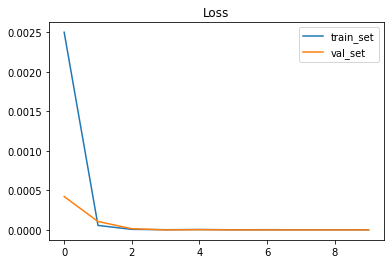

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train_set')
plt.plot(history.history['val_loss'], label='val_set')
plt.legend()
plt.show();

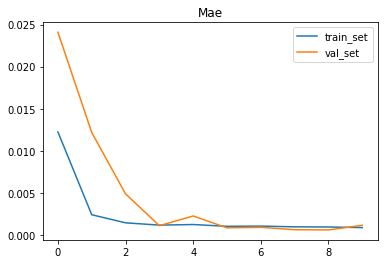

In [ ]:
plt.title('Mae')
plt.plot(history.history['mae'], label='train_set')
plt.plot(history.history['val_mae'], label='val_set')
plt.legend()
plt.show();